In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Lambda, Input, Dense, Reshape, RepeatVector, Dropout, Conv2D, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy, mean_absolute_error
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.constraints import unit_norm, max_norm

from scipy import stats
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import argparse
import os
from sklearn.manifold import MDS
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

# LOADING THE DATASET

In [2]:
hf=h5py.File("/scratch/p305197/my-test/notebooks/VAE/img_p+Fe_MST+SST_10000_NEW.hdf5", 'r')
hf.keys()

<KeysViewHDF5 ['MST', 'SST']>

# SST (48X48) and MST(112X112) IMAGES

In [3]:
data_MST = hf['MST']
data_SST = hf['SST']
data_MST.keys()

<KeysViewHDF5 ['ENERGY', 'EVENT_ID', 'LABEL', 'OBS_ID', 'XMAX', 'X_MONO', 'X_STEREO', 'Y']>

# MONO (1 TELESCOPE) and STEREO(>1 TELESCOPES)

In [4]:
imgs_MST_MONO = data_MST['X_MONO']
imgs_MST_STER = data_MST['X_STEREO']
imgs_SST_MONO = data_SST['X_MONO']
imgs_SST_STER = data_SST['X_STEREO']


# separated by species
imgs_MST_MONO_Fe = imgs_MST_MONO[0]
imgs_MST_MONO_p  = imgs_MST_MONO[1]
imgs_MST_STER_Fe = imgs_MST_STER[0]
imgs_MST_STER_p  = imgs_MST_STER[1]

imgs_SST_MONO_Fe = imgs_SST_MONO[0]
imgs_SST_MONO_p  = imgs_SST_MONO[1]
imgs_SST_STER_Fe = imgs_SST_STER[0]
imgs_SST_STER_p  = imgs_SST_STER[1]

#p+Fe images
imgs_MST_MONO_Fe_p = np.concatenate((imgs_MST_MONO_Fe, imgs_MST_MONO_p), axis=0)
imgs_MST_STER_Fe_p = np.concatenate((imgs_MST_STER_Fe, imgs_MST_STER_p), axis=0)

imgs_SST_MONO_Fe_p = np.concatenate((imgs_SST_MONO_Fe, imgs_SST_MONO_p), axis=0)
imgs_SST_STER_Fe_p = np.concatenate((imgs_SST_STER_Fe, imgs_SST_STER_p), axis=0)

# ENERGY, XMAX, Y

In [5]:
# XMAX by species
E_MST_Fe = data_MST['ENERGY'][0]
E_MST_p  = data_MST['ENERGY'][1]
XMAX_MST_Fe = data_MST['XMAX'][0]
XMAX_MST_p  = data_MST['XMAX'][1]

E_SST_Fe = data_SST['ENERGY'][0]
E_SST_p  = data_SST['ENERGY'][1]
XMAX_SST_Fe = data_SST['XMAX'][0]
XMAX_SST_p  = data_SST['XMAX'][1]

#p+Fe
E_MST_Fe_p = np.concatenate((E_MST_Fe,E_MST_p), axis=0)
E_SST_Fe_p = np.concatenate((E_SST_Fe,E_SST_p), axis=0)
XMAX_MST_Fe_p = np.concatenate((E_MST_Fe,E_MST_p), axis=0)
XMAX_SST_Fe_p = np.concatenate((E_SST_Fe,E_SST_p), axis=0)

# SETTING THE PARAMETERS

In [6]:
# Setting the Hyperparameters
## CNN Parameters 
# Drop out
dp = 0.25
# Number of Filters
n_ft = 24 #24
# Number of Conv Layers
n_conv = 3 #3
# Dimension of the Latent Space
latent_dim = 24
# L2 regularization
L2_reg= 0
# Learning Rate
lr = 0.001 #2e-3
# Epochs
epochs = 10 #200
# batch size
batch_size = 32 #64

# VAE-Loss
# reco_loss = 'binary'
reco_loss = 'mse' ## ANdres choice

# augmentation/transfromation of images
isAug = False # True
isFlip= False
isEdge= False
aug_size = 3000

# auxiliary variable
isVar = True #False
#aux_file = '../data/image_features_SST_MONO_Fe_p.csv'
aux_file = '/scratch/p305197/my-test/notebooks/VAE/data/image_features_SST_MONO_Fe_p.csv' ## For Andres's local folder
#yX    = aux_features(aux_file)[:,:-2]
yX    = XMAX_SST_Fe_p
#n_aux = yX.shape[1]
#n_aux = yX.shape[0]
#print(c)

# TRAIN/TEST SPLIT

In [7]:
# PARTICLE AND CASE
part = 'p+Fe'
caso = 'SST-MONO-'

dim_r = 1

if part=='p':
    caso = caso+part
    fold = 'Energy/Proton/'
elif part=='Fe':
    caso = caso+part
    fold = 'Energy/Iron/'
    
elif part=='p+Fe':
    caso = caso+part
    fold = 'Energy/Iron+Proton/'
    print('1111adsadasdas')

if caso=='SST-MONO-Fe':
    leg = r'Iron, $48\times 48$, Mono'
    data_images =imgs_SST_MONO_Fe
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe)
    yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    
elif caso=='SST-MONO-p+Fe':
    leg = r'Iron+Proton, $48\times 48$, Mono'
    data_images =imgs_SST_MONO_Fe_p
    dim_img = [data_images.shape[1],data_images.shape[2]]
    yE = np.log(E_SST_Fe_p)
    yE = E_SST_Fe_p
    #yX = aux_features(aux_file)[:,:-2] #not including E,Xmax
    yX = XMAX_SST_Fe_p
    print('asdadadasdasdasdas')

print(caso, dim_img, dim_r)
fake = np.zeros((data_images.shape[0]))
pred = np.zeros((yE.shape))

1111adsadasdas
asdadadasdasdasdas
SST-MONO-p+Fe [48, 48] 1


In [8]:
max(yE), min(yE)

(299.6600036621094, 1.0016049146652222)

In [9]:
np.shape(data_images), np.shape(yX)

((20000, 48, 48, 1), (20000,))

In [10]:
from sklearn.model_selection import StratifiedKFold, train_test_split
caso

'SST-MONO-p+Fe'

In [11]:
# Train/Test split
rs = 42
if isEdge:
    #data_images = median_filter(data_images,2)
    data_images = enhance_edges(data_images)
    
train_data, test_data, train_e, test_e = train_test_split(data_images,yE,test_size=0.33,
                                                          shuffle=True,random_state=rs)

_, _, train_xmax, test_xmax            = train_test_split(data_images,yX,test_size=0.33,
                                                          shuffle=True,random_state=rs)


In [12]:
np.shape(train_data), np.shape(test_data), np.shape(train_e), np.shape(test_e), np.shape(train_xmax), np.shape(test_xmax)

((13400, 48, 48, 1), (6600, 48, 48, 1), (13400,), (6600,), (13400,), (6600,))

In [13]:
train_e = train_e.reshape(len(train_e),1)
test_e  = test_e.reshape(len(test_e),1)
train_xmax  = train_xmax.reshape(len(train_xmax),1)
test_xmax  = test_xmax.reshape(len(test_xmax),1)

In [14]:
np.shape(train_e)

(13400, 1)

# VARIATIONAL AUTO-ENCODER MODEL

In [15]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    thre = K.random_uniform(shape=(batch,1))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [278]:
# Load Toy Example Data
training_feature = np.loadtxt('X.txt')
training_feature.shape

Y = np.loadtxt('Y.txt')
ground_truth_r = Y

np.random.seed(seed=0)

original_dim = training_feature.shape[1]
num_train = training_feature.shape[0]

In [281]:
np.shape(training_feature), np.shape(ground_truth_r)

((245, 301), (245,))

In [196]:
# Load Toy Example Data
training_feature_pre = np.log10(train_e)
training_feature_pre.shape

Y = np.log10(train_e)
ground_truth_r = Y

np.random.seed(seed=0)

original_dim = training_feature_pre.shape[1]
num_train = training_feature_pre.shape[0]

In [197]:
training_feature_pre

array([[1.72903612],
       [0.29979426],
       [1.34260876],
       ...,
       [0.91411159],
       [2.00351504],
       [0.21171079]])

In [173]:
def normalize(input_list):
    #std_dev = np.std(input_list)
    #mean = np.mean(input_list)
    #normalised_input = (input_list - mean) / std_dev 
    #return normalised_input

    x_min = np.min(input_list)
    x_max = np.max(input_list)
    delta = x_max-x_min
    return (input_list-x_min)/delta

In [198]:
training_feature = training_feature_pre #normalize(training_feature_pre)
Y = training_feature_pre #normalize(np.log10(train_e))
ground_truth_r = Y

In [199]:
training_feature

array([[1.72903612],
       [0.29979426],
       [1.34260876],
       ...,
       [0.91411159],
       [2.00351504],
       [0.21171079]])

In [200]:
ground_truth_r

array([[1.72903612],
       [0.29979426],
       [1.34260876],
       ...,
       [0.91411159],
       [2.00351504],
       [0.21171079]])

In [201]:
original_dim, num_train

(1, 13400)

In [202]:
from tensorflow.keras.layers import Conv2D, MaxPool2D
original_dim, num_train

(1, 13400)

In [203]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

AttributeError: module 'tensorflow' has no attribute 'GPUOptions'

In [282]:
## Build VAE-Regression Model
input_shape_x = (original_dim, )
input_shape_r = (1, )

intermediate_dim = 32
batch_size = 64
latent_dim = 16
epochs = 4

# VAE model = encoder + decoder
# build encoder model
inputs_r = Input(shape=input_shape_r, name='ground_truth')
inputs_x = Input(shape=input_shape_x, name='encoder_input')
inputs_x_dropout = Dropout(0.25)(inputs_x)

#inputs_r = Input(shape=(original_dim, original_dim, 1), name='ground_truth')
#inputs_x = Input(shape=(original_dim, original_dim, 1), name='encoder_input')
#inputs_x = Conv2D(input_shape=(original_dim, original_dim, 1),filters=64,kernel_size=(3,3),padding="same", activation="relu")(inputs_x)
#inputs_x = Conv2D(64, kernel_size=(3, 3),padding='same')(inputs_x)
#inputs_x_dropout = Dropout(0.25)(inputs_x)
#inputs_x_dropout = Flatten()(inputs_x_dropout)

inter_x1 = Dense(128, activation='tanh', name='encoder_intermediate')(inputs_x_dropout)
inter_x2 = Dense(intermediate_dim, activation='tanh', name='encoder_intermediate_2')(inter_x1)

# posterior on Y; probablistic regressor
r_mean = Dense(1, name='r_mean')(inter_x2)
r_log_var = Dense(1, name='r_log_var')(inter_x2)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x2)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x2)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
r = Lambda(sampling, output_shape=(1,), name='r')([r_mean, r_log_var])

# latent generator (simplified)
pz_mean = Dense(latent_dim, name='pz_mean',kernel_constraint=unit_norm())(r)
# pz_log_var = Dense(1, name='pz_log_var')(r)

# instantiate encoder model
encoder = Model([inputs_x,inputs_r], [z_mean, z_log_var, z, r_mean, r_log_var, r, pz_mean], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim, activation='tanh')(latent_inputs)
inter_y2 = Dense(128, activation='tanh')(inter_y1)
outputs = Dense(original_dim)(inter_y2)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder([inputs_x,inputs_r])[2])
vae = Model([inputs_x,inputs_r], outputs, name='vae_mlp')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 301)]        0           []                               
                                                                                                  
 dropout_19 (Dropout)           (None, 301)          0           ['encoder_input[0][0]']          
                                                                                                  
 encoder_intermediate (Dense)   (None, 128)          38656       ['dropout_19[0][0]']             
                                                                                                  
 encoder_intermediate_2 (Dense)  (None, 32)          4128        ['encoder_intermediate[0][0]']   
                                                                                            

In [299]:
## Build VAE-Regression Model
input_shape_x = (original_dim, )
input_shape_r = (1, )

intermediate_dim = 32
batch_size = 64
latent_dim = 8
epochs = 100

# VAE model = encoder + decoder
# build encoder model
inputs_r = Input(shape=input_shape_r, name='ground_truth')
inputs_x = Input(shape=input_shape_x, name='encoder_input')
inputs_x_dropout = Dropout(0.25)(inputs_x)

inter_x1 = Dense(128, activation='tanh', name='encoder_intermediate')(inputs_x_dropout)
inter_x2 = Dense(intermediate_dim, activation='tanh', name='encoder_intermediate_2')(inter_x1)

# posterior on Y; probablistic regressor
r_mean = Dense(1, name='r_mean')(inter_x2)
r_log_var = Dense(1, name='r_log_var')(inter_x2)

# q(z|x)
z_mean = Dense(latent_dim, name='z_mean')(inter_x2)
z_log_var = Dense(latent_dim, name='z_log_var')(inter_x2)

# use reparameterization trick to push the sampling out as input
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
r = Lambda(sampling, output_shape=(1,), name='r')([r_mean, r_log_var])

# latent generator (simplified)
pz_mean = Dense(latent_dim, name='pz_mean',kernel_constraint=unit_norm())(r)
# pz_log_var = Dense(1, name='pz_log_var')(r)

# instantiate encoder model
encoder = Model([inputs_x,inputs_r], [z_mean, z_log_var, z, r_mean, r_log_var, r, pz_mean], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
inter_y1 = Dense(intermediate_dim, activation='tanh')(latent_inputs)
inter_y2 = Dense(128, activation='tanh')(inter_y1)
outputs = Dense(original_dim)(inter_y2)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder([inputs_x,inputs_r])[2])
vae = Model([inputs_x,inputs_r], outputs, name='vae_mlp')
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 301)]        0           []                               
                                                                                                  
 dropout_20 (Dropout)           (None, 301)          0           ['encoder_input[0][0]']          
                                                                                                  
 encoder_intermediate (Dense)   (None, 128)          38656       ['dropout_20[0][0]']             
                                                                                                  
 encoder_intermediate_2 (Dense)  (None, 32)          4128        ['encoder_intermediate[0][0]']   
                                                                                            

In [300]:
import tensorflow as tf
from tensorflow.keras import backend as K

In [301]:
##Customize Lost Function of the VAE Model
models = (encoder, decoder)

#reconstruction_loss = K.tf.divide(0.5*K.sum(K.square(inputs_x-outputs), axis=-1), K.exp(outputs_var)) + 0.5*original_dim*outputs_var
#reconstruction_loss = mse(inputs_x,outputs)
reconstruction_loss = mean_absolute_error(inputs_x,outputs)


#kl_loss = 1 + z_log_var - pz_log_var - K.tf.divide(K.square(z_mean-pz_mean),K.exp(pz_log_var)) - K.tf.divide(K.exp(z_log_var),K.exp(pz_log_var))
kl_loss = 1 + z_log_var - K.square(z_mean-pz_mean) - K.exp(z_log_var)
kl_loss = -0.5*K.sum(kl_loss, axis=-1)
label_loss = tf.divide(0.5*K.square(r_mean - inputs_r), K.exp(r_log_var)) +  0.5 * r_log_var

vae_loss = K.mean(reconstruction_loss+kl_loss+label_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
vae.save_weights('random_weights.h5')

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 301)]        0           []                               
                                                                                                  
 ground_truth (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 encoder (Functional)           [(None, 8),          43394       ['encoder_input[0][0]',          
                                 (None, 8),                       'ground_truth[0][0]']           
                                 (None, 8),                                                       
                                 (None, 1),                                                 

In [302]:
ground_truth_r.shape,ground_truth_r.shape[0]

((245,), 245)

In [303]:
# ref: https://stackoverflow.com/questions/41117740/tensorflow-crashes-with-cublas-status-alloc-failed
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = 
                         tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
# device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [304]:
intermediate_dim = 32
batch_size = 64
latent_dim = 8
epochs = 100

In [305]:
## Train the network
np.random.seed(0)
skf = StratifiedKFold(n_splits=10)
pred = np.zeros((ground_truth_r.shape))
fake = np.zeros((ground_truth_r.shape[0]))
fake[:300] = 1

# Run 5-fold CV
for train_idx, test_idx in skf.split(training_feature,fake):
    print(train_idx, test_idx, len(train_idx), len(test_idx), len(test_idx)/ground_truth_r.shape[0])
    training_feature_sk = training_feature[train_idx,:]
    training_score = ground_truth_r[train_idx]
    
    testing_feature_sk = training_feature[test_idx,:]
    testing_score = ground_truth_r[test_idx]    
    print(np.shape(testing_feature_sk), np.shape(testing_score))
    vae.load_weights('random_weights.h5')
    vae.fit([training_feature_sk,training_score],epochs=epochs,batch_size=batch_size,verbose = 1)
    
    
    [z_mean, z_log_var, z, r_mean, r_log_var, r_vae, pz_mean] = encoder.predict([testing_feature_sk,testing_score],batch_size=batch_size)
    pred[test_idx] = r_mean[:,0]
    #pred[test_idx] = r_mean[:]
    break

[ 25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42
  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240
 241 242 243 244] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24] 220 25 0.10204081632653061
(

Epoch 92/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5487
Epoch 93/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7251
Epoch 94/100
4/4 [==============================] - 0s 5ms/step - loss: 0.6765
Epoch 95/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5463
Epoch 96/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7163
Epoch 97/100
4/4 [==============================] - 0s 5ms/step - loss: 0.4345
Epoch 98/100
4/4 [==============================] - 0s 5ms/step - loss: 0.7046
Epoch 99/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5544
Epoch 100/100
4/4 [==============================] - 0s 5ms/step - loss: 0.5933


In [296]:
np.shape(r_mean),np.shape(r_mean[:,0]), np.shape(pred), test_idx

((25, 1),
 (25,),
 (245,),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]))

In [306]:
#pred[test_idx] = r_mean[:,0]
pred, ground_truth_r

(array([-0.74320394,  0.12809403,  0.10396877,  1.40283883, -0.94259197,
         0.90116143,  1.13273227, -0.39386222, -0.11633682,  0.79163867,
         0.83176035,  0.10884847, -0.5979082 ,  0.9278056 , -1.18247807,
         0.0268993 , -1.27427018, -0.79883569, -1.28786337,  1.22814882,
        -0.76249009,  0.89444298, -1.24995983,  1.28818166,  0.80020034,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

Mean squared error: 0.879
R2 Variance score: 0.118


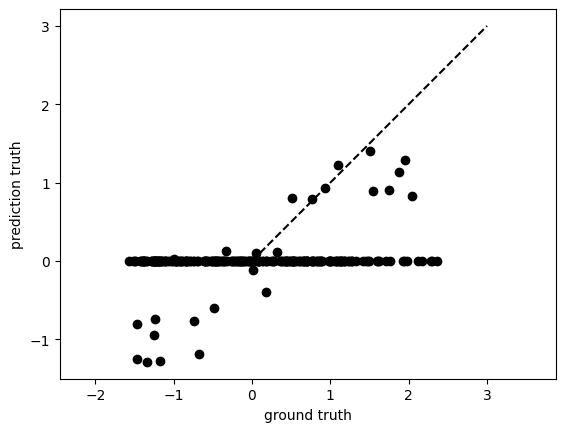

In [307]:
## Validation
# The mean squared error
print("Mean squared error: %.3f" % mean_squared_error(ground_truth_r, pred))
# Explained variance score: 1 is perfect prediction
print('R2 Variance score: %.3f' % r2_score(ground_truth_r, pred))

# Plot Prediction vs. Ground-truth Y
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(ground_truth_r, pred,  color='black')
ax.plot([0, 3], [0, 3], ls="--", c="black")
plt.xlabel('ground truth')
plt.ylabel('prediction truth')
ax.axis('equal');

/scratch/p305197/.envs/dl1dh_habrok/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(-3.4484167859147083,
 3.736300861731021,
 -3.4133124723511434,
 3.531115346553621)

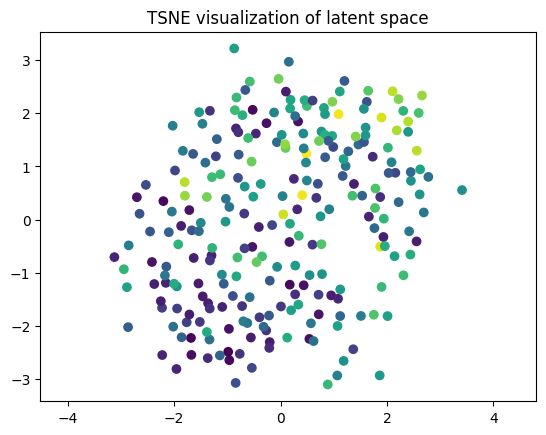

In [293]:
## Visualize Latent Space
vae.load_weights('random_weights.h5')
vae.fit([training_feature,ground_truth_r],
         epochs=epochs,
         batch_size=batch_size,
         verbose = 0)
 
[z_mean, z_log_var, z, r_mean, r_log_var, r_vae, pz_mean] = encoder.predict([training_feature,ground_truth_r],batch_size=batch_size)

tsne = MDS(n_components=2, random_state=0)
X_2d = tsne.fit_transform(z_mean)

#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_2d[:, 0], X_2d[:, 1], c=ground_truth_r)
plt.title('TSNE visualization of latent space')
ax.axis('equal')
